In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
#import lightgbm as lgb
import datetime as dt
import calendar,warnings,itertools,matplotlib,shutil
#import tensorflow as tf
#import keras
import statsmodels.api as sm
from datetime import datetime

In [9]:
#Importing Dataset using pandas
dataset=pd.read_csv("DataCoSupplyChainDataset.csv", encoding= 'unicode_escape')

In [10]:
dataset.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [11]:
dataset.shape

(180519, 53)

In [12]:
dataset.isnull().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [14]:
# Adding first name and last name together to create new column
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)

In [15]:
data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 42)

In [16]:
data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)#Filling NaN columns with zero

In [17]:
dataset.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


<AxesSubplot:>

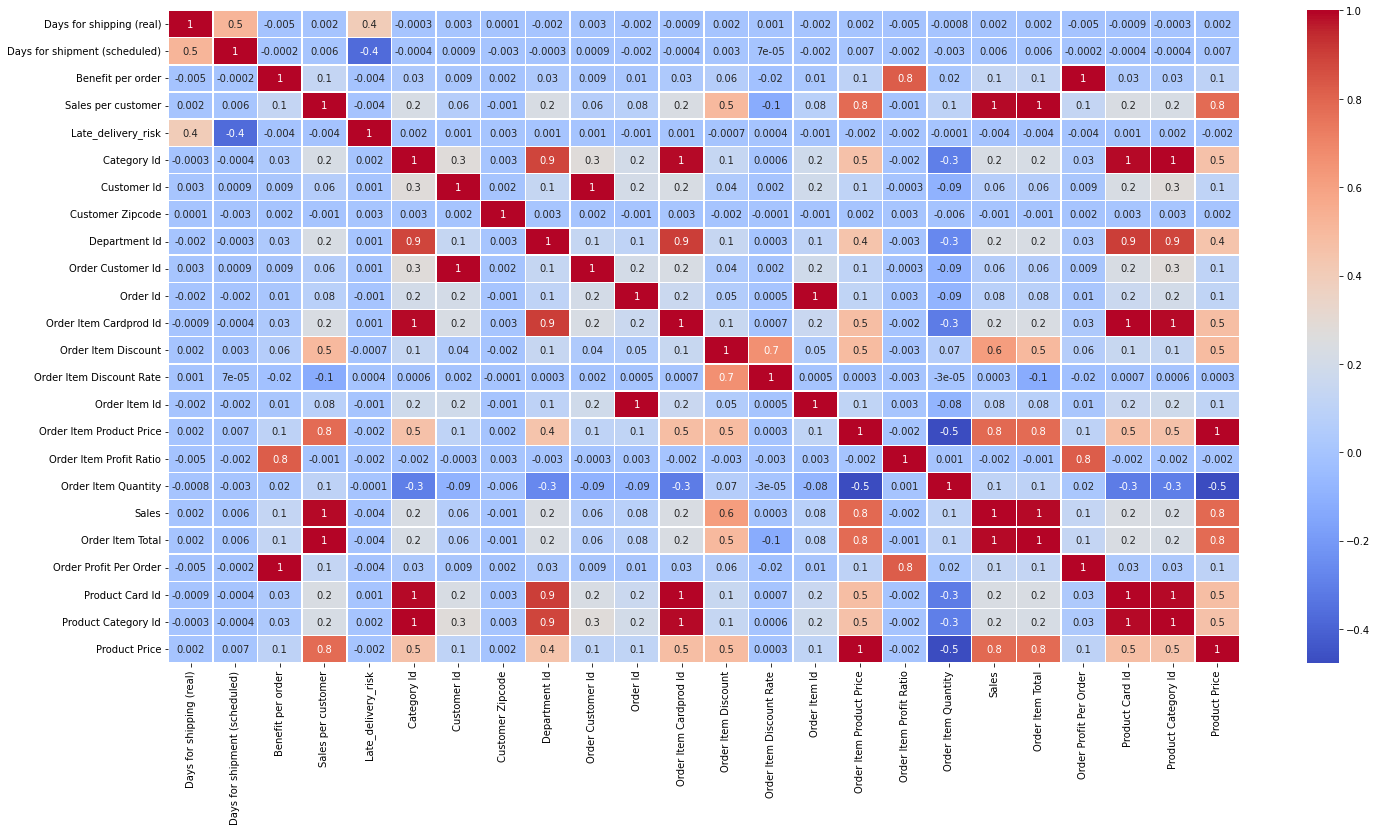

In [20]:
fig, ax = plt.subplots(figsize=(24,12)) 
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix


<AxesSubplot:title={'center':'Total sales for all regions'}, xlabel='Order Region'>

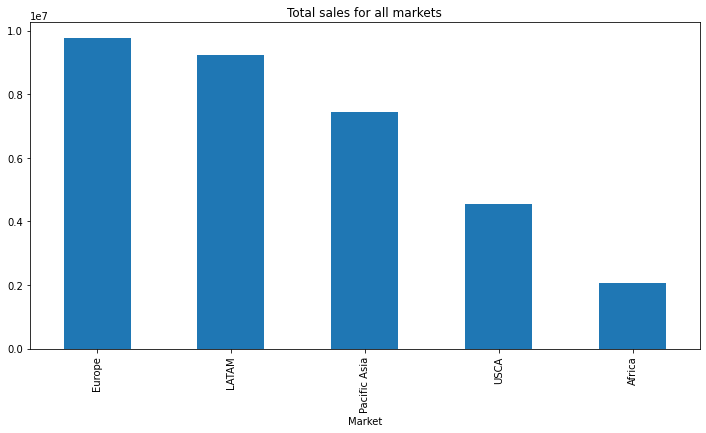

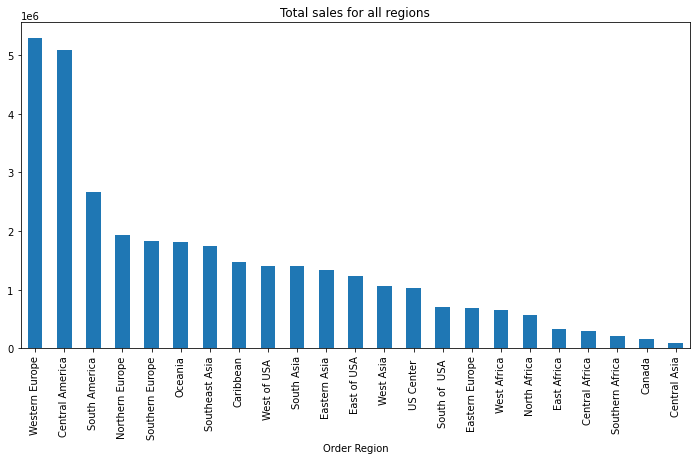

In [21]:
market = data.groupby('Market') #Grouping by market
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all regions")

<AxesSubplot:title={'center':'Average price'}, xlabel='Category Name'>

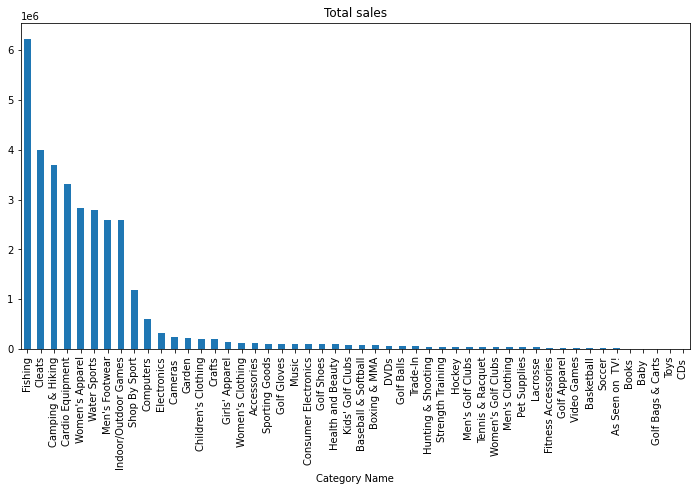

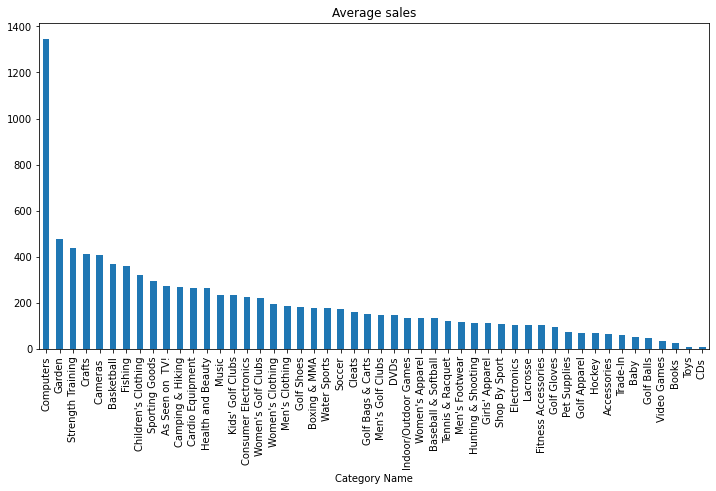

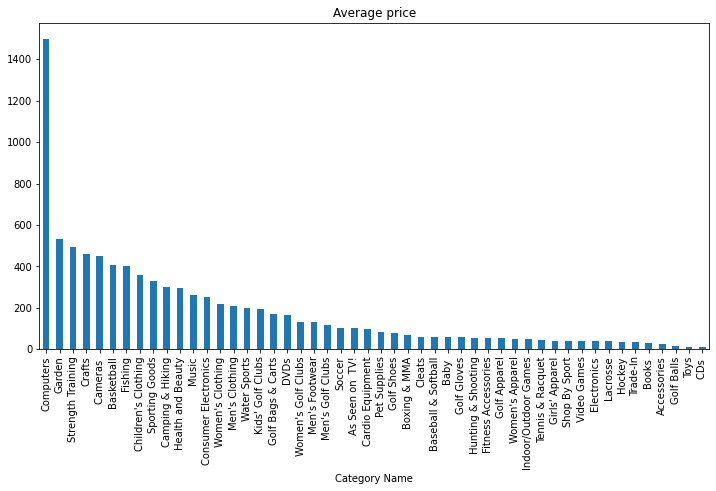

In [22]:
#Grouping all categories
cat = data.groupby('Category Name')
plt.figure(1)
# Total sum of sales for all categories
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales")
# Mean sales for all categories
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average sales")
plt.figure(3)
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average price")